<h1 align='center'>Introdução à Computação Visual - 2022/1</h1>
<h3 align='center'>Trabalho Prático 2: Realidade Aumentada</h3>

Autor: Flávio Marcilio de Oliveira

## 0. Preparação

**Esta etapa deve ser executada antes de todo o processo.**

### Bibliotecas Necessárias

In [1]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

from OpenGL.GLUT import *
from OpenGL.GL import *
from OpenGL.GLU import *

from objloader import *

pygame 2.1.2 (SDL 2.0.18, Python 3.9.4)
Hello from the pygame community. https://www.pygame.org/contribute.html


### Funções Auxiliares

In [2]:
# Configuração da apresentação da imagem
def mostra_img_unica(img, titulo='Imagem'):
    plt.figure(figsize=(15,10))
    plt.imshow(img, cmap='gray', clim=(0,255))
    plt.title(titulo)
    plt.axis('off')
    plt.show()

## 1. Calibração da Câmera

Estimação dos parâmetros intrínsecos da câmera. Sendo a distância focal dada por f e o ponto principal dado por c.

$$
\begin{bmatrix}
x \\
y \\
z
\end{bmatrix} = \begin{bmatrix}
 f_x & 0 & c_x \\
 0 & f_y & c_y \\
 0 & 0 & 1
\end{bmatrix}
\begin{bmatrix}
X_c \\
Y_c \\
Z_c
\end{bmatrix}
$$

$$
p = M_{int}P_c
$$

A matriz de parâmetros intrínsecos da câmera faz a transformação do sistema de coordenadas da câmera para o sistema de coordenadas em pixels. Essa matriz é determinada através do processo de calibração utilizando o tabuleiro de xadrez como alvo. Esta calibração é feita utilizando o toolbox de Jean-Yves Bouguet para Octave (https://github.com/nghiaho12/camera_calibration_toolbox_octave).

In [3]:
# Matriz de parâmetros intrínsecos
cameraMatrix = np.array([[420.376618170087454, 0, 309.519760110345203], 
                  [0, 417.040317169641469, 222.549608431925293],
                  [0, 0, 1]])

# Vetor de coeficientes de distorção
distCoeffs = np.array([0.115831342254891, -0.445977051467357, -0.005642713618645, -0.005181290112430, 0.000000000000000])

print("\nMatriz de parâmetros intrínsicos:")
print(cameraMatrix)

print("\nVetor de coeficientes de distorção:")
print(distCoeffs)


Matriz de parâmetros intrínsicos:
[[420.37661817   0.         309.51976011]
 [  0.         417.04031717 222.54960843]
 [  0.           0.           1.        ]]

Vetor de coeficientes de distorção:
[ 0.11583134 -0.44597705 -0.00564271 -0.00518129  0.        ]


## 2. Etapas para Detecção do alvo

Definição do método de detecção e localização da posição e orientação do alvo em cada frame do vídeo. Abaixo serão mostradas as etapas utilizadas para implementar o método de detecção do alvo na cena.

### 2.1 Ler o vídeo

In [4]:
video = cv.VideoCapture('entrada.mp4')
frames = []
while(True):
    ret, frame = video.read()
    if ret:
        frames.append(frame)
    else: 
        break

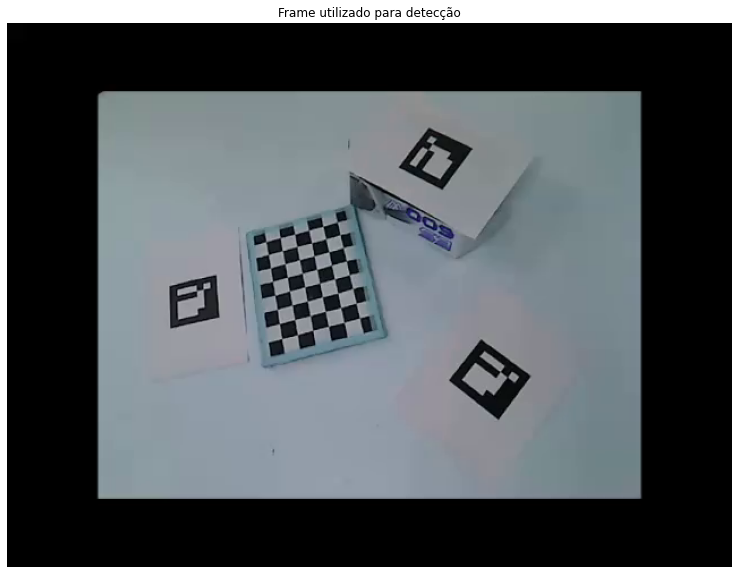

In [5]:
# Frame utilizado para a detecção
frame = frames[0]
mostra_img_unica(frame, "Frame utilizado para detecção")

### 2.2 Transformar o frame em escala de cinza

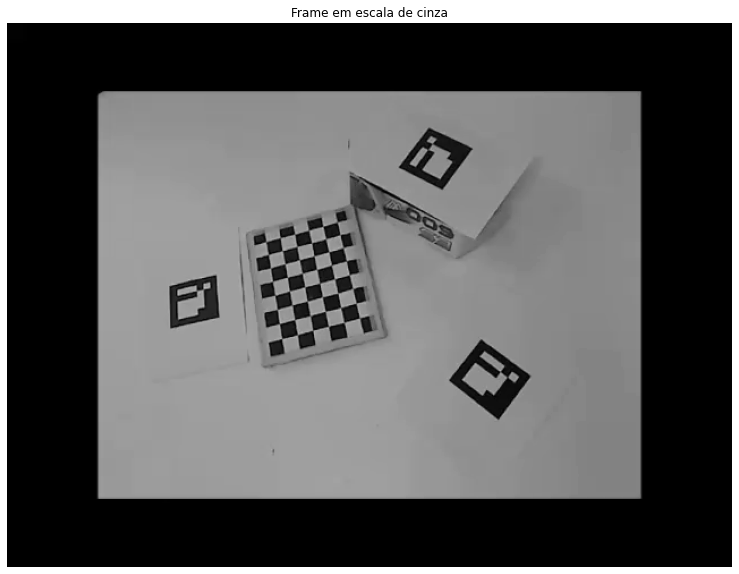

In [6]:
grayframe = cv.cvtColor(src=frame, code=cv.COLOR_BGR2GRAY)
mostra_img_unica(grayframe, "Frame em escala de cinza")

### 2.3 Encontrar as bordas com o algoritmo de Canny

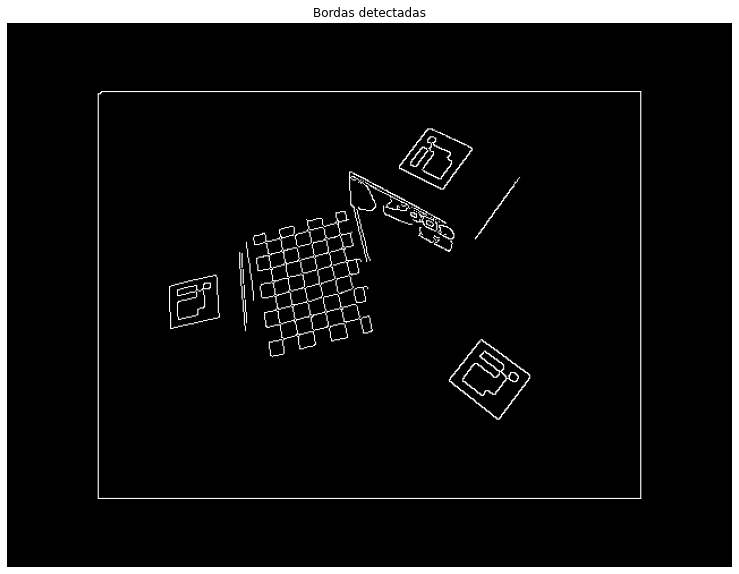

In [7]:
dst = cv.Canny(image=grayframe, threshold1=127, threshold2=255, apertureSize=None, L2gradient=3)
mostra_img_unica(dst, "Bordas detectadas")

### 2.4 Detectar os contornos

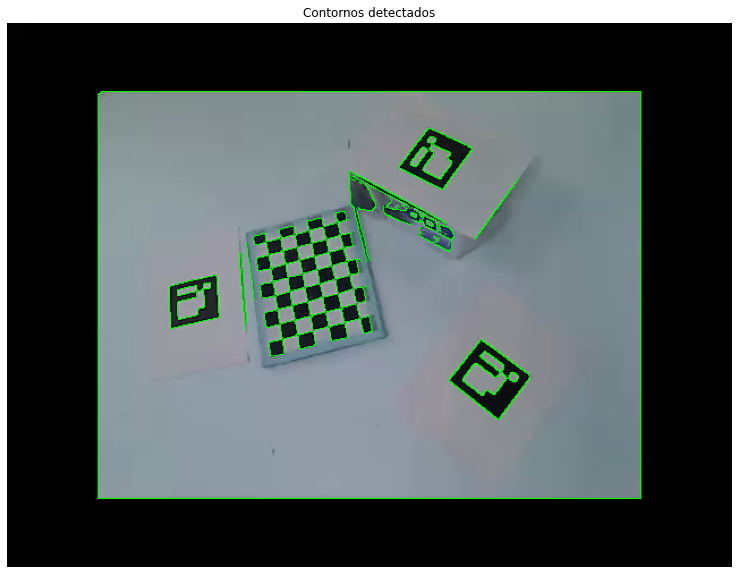

In [8]:
contours, hierarchy = cv.findContours(image=dst, mode=cv.RETR_TREE, method=cv.CHAIN_APPROX_SIMPLE)
contoursFrame = frame.copy()
cv.drawContours(contoursFrame, contours, -1, (0,255,0), 1)
mostra_img_unica(contoursFrame, "Contornos detectados")

### 2.5 Filtrar os contornos para diminuir o espaço de busca

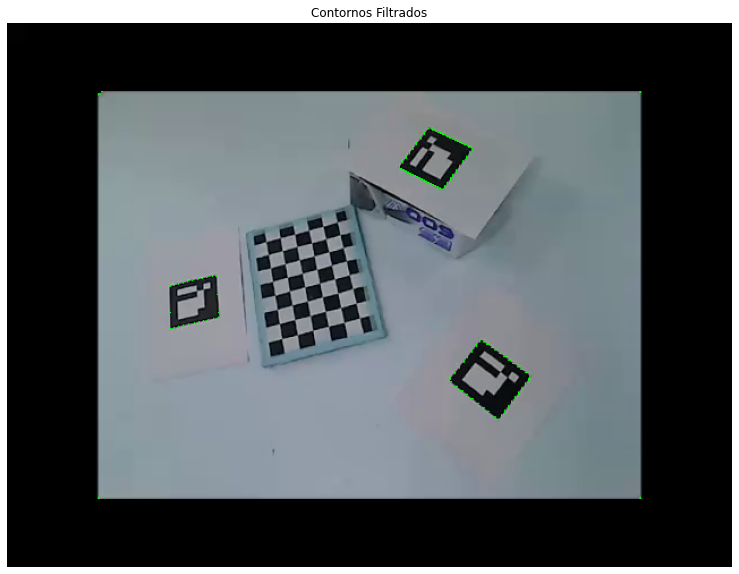

In [9]:
squareContours = []
for contour in contours:
    perimeter = cv.arcLength(curve=contour, closed=True)
    approxCurve = cv.approxPolyDP(curve=contour, epsilon=0.01 * perimeter, closed=True)
    if len(approxCurve) == 4:
        squareContours.append(contour)
        
squareFrame = frame.copy()
for contour in squareContours:
    cv.drawContours(squareFrame, contour, -1, (0,255,0), 1)

mostra_img_unica(squareFrame, "Contornos Filtrados")

### 2.6 Selecionar os pontos das quinas

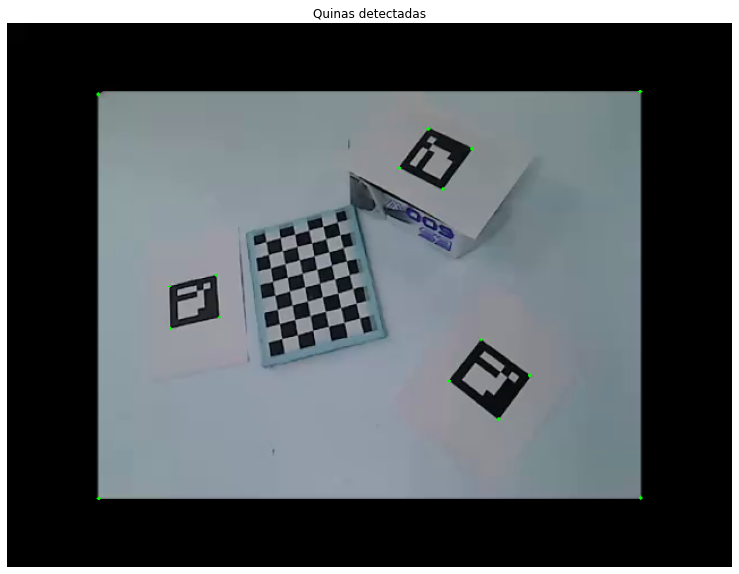

In [10]:
corners = []
for contour in squareContours:
    perimeter = cv.arcLength(curve=contour, closed=True)
    approxCurve = cv.approxPolyDP(curve=contour, epsilon=0.01 * perimeter, closed=True)
    corners.append(approxCurve)

cornerFrame = frame.copy()
for corner in corners:
    cv.drawContours(cornerFrame, corner, -1, (0,255,0), 2)

mostra_img_unica(cornerFrame, "Quinas detectadas")

### 2.7 Calcular a homografia para os pontos detectados

(-0.5, 303.5, 303.5, -0.5)

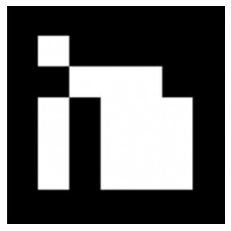

In [11]:
# Alvo a ser encontrado na cena
image_path = "target/alvo.jpg"
target = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
h, w = target.shape
objPoints = np.array([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]])
plt.imshow(target, cmap='gray')
plt.axis("off")

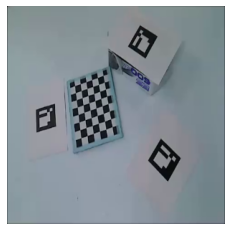

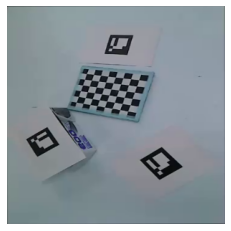

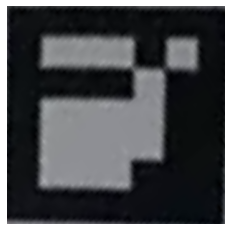

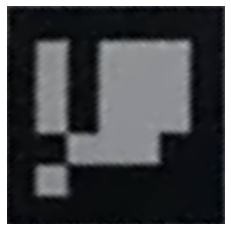

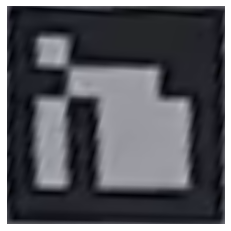

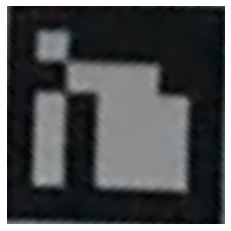

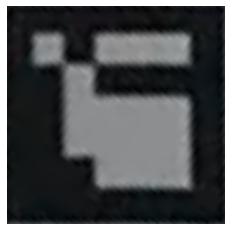

In [12]:
# Determinando a homografia e a imagem retificada para os pontos determinados
homographies = []
transformadas = []
for corner in corners:
    homography, mask = cv.findHomography(corner, objPoints, cv.RANSAC, 5.0)
    transformada = cv.warpPerspective(src=frame, M=homography, dsize=(h, w))
    transformadas.append(transformada)
    homographies.append(homography)

for item in transformadas:
    plt.imshow(item, cmap='gray')
    plt.axis("off")
    plt.show()

### 2.8 Detectar quais pontos corresponde ao alvo e sua orientação

Nesta etapa, será utilizado o método de Casamento de Template e a similaridade será calculada através da **Correlação Cruzada Normalizada** dada pela equação:

$$
ncc(I_1, I_2) = \frac{1}{n-1}\sum_{X}\frac{(I_{1(X)}-\mu_1)}{\sigma_1}\cdot \frac{(I_{2(X)}-\mu_2)}{\sigma_2}
$$

Uma correlação cruzada normalizada acima de 0.4 será considerado bom correspondência, sendo indicado a direção encontrada pelos índices 0, 1, 2 e 3. A não correspondência será indicada por 4.

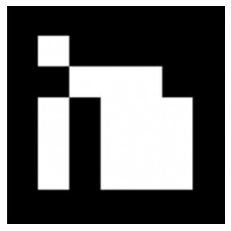

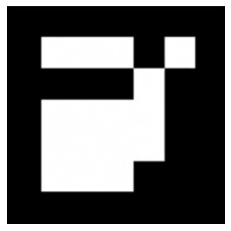

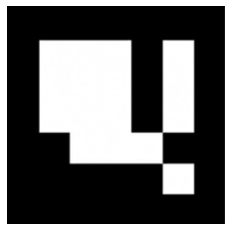

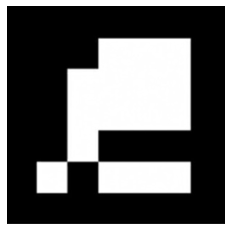

In [13]:
# Obtendo as rotações do alvo
target_rot0 = target.copy()
target_rot1 = cv.rotate(target, cv.ROTATE_90_CLOCKWISE)
target_rot2 = cv.rotate(target, cv.ROTATE_180)
target_rot3 = cv.rotate(target, cv.ROTATE_90_COUNTERCLOCKWISE)

targets = [target_rot0, target_rot1, target_rot2, target_rot3]

for item in targets:
    plt.imshow(item, cmap='gray')
    plt.axis("off")
    plt.show()

In [14]:
# Correlação Cruzada Normalizada
def crossCorrelation(image1, image2):
    diff_1 = image1 - image1.mean()
    diff_2 = image2 - image2.mean()
    div1 = diff_1/image1.std()
    div2 = diff_2/image2.std()
    return np.mean(div1 * div2)

In [15]:
orientacoes = []
for transformada in transformadas:
    # Binarizando a imagem retificada
    gray = cv.cvtColor(src=transformada, code=cv.COLOR_BGR2GRAY)
    ret, thresh = cv.threshold(src=gray, thresh=100, maxval=255, type=cv.THRESH_BINARY)
    hThresh, wThresh = thresh.shape

    # Reescala os alvos para o tamanho da transformada
    resizeTarget = [cv.resize(targets[0], (wThresh, hThresh)), 
                    cv.resize(targets[1], (wThresh, hThresh)), 
                    cv.resize(targets[2], (wThresh, hThresh)), 
                    cv.resize(targets[3], (wThresh, hThresh))]

    # Compara os alvos com a transformada
    goodMatch = 0
    orientacao = 0
    for i in range(len(targets)):
        cc = crossCorrelation(thresh, resizeTarget[i])
        if cc > goodMatch:
            goodMatch = cc
            orientacao = i
            
    # Verifica se os pontos correspondem a um alvo de fato
    if goodMatch < 0.4:
        orientacao = 4

    orientacoes.append(orientacao)

print(orientacoes)

[4, 4, 1, 2, 0, 0, 3]


### 2.9 Funções com as etapas desenvolvidas

In [16]:
# Função para detectar possíveis alvos na imagem
def findTarget(frame):
    # 2.2 Convertendo o frame para escala de cinza
	grayframe = cv.cvtColor(src=frame, code=cv.COLOR_BGR2GRAY)

    # 2.3 Encontrando as bordas com o algoritmo de Canny
	dst = cv.Canny(image=grayframe, threshold1=127, threshold2=255, apertureSize=None, L2gradient=3)

	# 2.4 Detectando os contornos
	contours, hierarchy = cv.findContours(image=dst, mode=cv.RETR_TREE, method=cv.CHAIN_APPROX_NONE)

	# 2.5 Filtrando os contornos para pegar somente os quadrados
	squareContours = []
	for contour in contours:
		perimeter = cv.arcLength(curve=contour, closed=True)
		approxCurve = cv.approxPolyDP(curve=contour, epsilon=0.01 * perimeter, closed=True)
		if len(approxCurve) == 4:
			squareContours.append(contour)
	
	# 2.6 Selecionando os pontos das quinas
	corners = []
	for contour in squareContours:
		perimeter = cv.arcLength(curve=contour, closed=True)
		approxCurve = cv.approxPolyDP(curve=contour, epsilon=0.01 * perimeter, closed=True)
		corners.append(approxCurve)

	return corners

In [17]:
def findRotation(frame, imgPoints, targets):
    target = targets[0]
    h, w = target.shape
    objPoints = np.array([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]])

    # 2.7 Determinando a homografia
    homography, mask = cv.findHomography(srcPoints=imgPoints, dstPoints=objPoints, method=cv.RANSAC, ransacReprojThreshold=5.0)

    # 2.8 Detectando se corresponde ao alvo e a orientação caso positivo
    # Retificando a imagem retirando a distorção perspectiva
    transformada = cv.warpPerspective(src=frame, M=homography, dsize=(h, w))

    # Binarizando a imagem retificada
    gray = cv.cvtColor(src=transformada, code=cv.COLOR_BGR2GRAY)
    ret, thresh = cv.threshold(src=gray, thresh=100, maxval=255, type=cv.THRESH_BINARY)
    hThresh, wThresh = thresh.shape

    # Reescalando os alvos para o tamanho da imagem retificada
    resizeTarget = [cv.resize(targets[0], (wThresh, hThresh)), 
                    cv.resize(targets[1], (wThresh, hThresh)), 
                    cv.resize(targets[2], (wThresh, hThresh)), 
                    cv.resize(targets[3], (wThresh, hThresh))]
    
    # Comparando os alvos com a imagem retificada
    goodMatch = 0
    orientacao = 0
    for i in range(len(targets)):
        cc = crossCorrelation(thresh, resizeTarget[i])
        if cc > goodMatch:
            goodMatch = cc
            orientacao = i
            
    # Verifica se os pontos correspondem a um alvo de fato
    if goodMatch < 0.4:
        return 4
    
    return orientacao

### 2.10 Detecção dos Alvos no vídeo

In [18]:
def draw(frame, imgpts):
    imgpts = np.int32(imgpts).reshape(-1,2)
    frame = cv.drawContours(frame, [imgpts[:4]], -1, (0,255,0), 2)
    return frame

In [19]:
# Lendo o vídeo do arquivo
vid_capture = cv.VideoCapture('entrada.mp4')
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
while(vid_capture.isOpened()):
	ret, frame = vid_capture.read()
	if ret == True:
		# Detectando os candidatos a alvo
		candidates = findTarget(frame=frame)
		for candidate in candidates:
			targetDetected = findRotation(frame=frame, imgPoints=candidate, targets=targets)
			if targetDetected == 4:
				continue
			else:
				frame = draw(frame, candidate)
				
		cv.imshow('Detectando os alvos', frame)
		key = cv.waitKey(20)
		
		if key == ord('q'):
			break
	else:
		break

# Release the video capture object
vid_capture.release()
cv.destroyAllWindows()

<ipython-input-14-465e35d19559>:5: RuntimeWarning: invalid value encountered in true_divide
  div1 = diff_1/image1.std()


## 3. Obtenção da pose da câmera

Determinação dos parâmetros extrínsecos da câmera.

$$
P_c = M_{ext}P_w = RTP_w
$$

$$
\begin{bmatrix}
X_c \\
Y_c \\
Z_c \\
W
\end{bmatrix} = \begin{bmatrix}
 r_{11} & r_{12} & r_{13} & t_x \\
 r_{21} & r_{22} & r_{23} & t_y \\
 r_{31} & r_{32} & r_{33} & t_z \\
 0    & 0    & 0    & 1
\end{bmatrix} \begin{bmatrix}
X_w \\
Y_w \\
Z_w \\
1
\end{bmatrix}
$$

A matriz de parâmetros extrínsecos faz a transformação do sistema de coordenadas do mundo para o sistema de coordenadas da câmera.


In [20]:
def getPose(imagePoints, orientacao):
    
    # Frame de referência para cálculo da pose da câmera
    objectPoints = np.array([[-0.5, -0.5, 0.0], 
                             [ 0.5, -0.5, 0.0],
                             [ 0.5,  0.5, 0.0], 
                             [-0.5,  0.5, 0.0],
                             [-0.5, -0.5, 0.5], 
                             [ 0.5, -0.5, 0.5],
                             [ 0.5,  0.5, 0.5], 
                             [-0.5,  0.5, 0.5]])

    
    # Correção dos índices do frame de referência utilizando a orientação como base
    indices = np.arange(4)
    indices += orientacao
    indices %= 4

    imgpts = np.float32(imagePoints.reshape(4,2))

    objp = np.float32(objectPoints[indices])

    # Estima a pose da câmera
    val, rvecs, tvecs, inliers = cv.solvePnPRansac(objectPoints=objp, imagePoints=imgpts, 
                                                   cameraMatrix=cameraMatrix, distCoeffs=distCoeffs)

    return (objectPoints, rvecs, tvecs)

## 4. Inclusão do cubo (objeto tridimensional) na cena

In [21]:
def drawCube(frame, imgpts):
    imgpts = np.int32(imgpts).reshape(-1,2)
    # draw ground floor
    frame = cv.drawContours(frame, [imgpts[:4]], -1, (0,255,0), 2)

    # draw pillars
    for i,j in zip(range(4), range(4,8)):
        frame = cv.line(frame, tuple(imgpts[i]), tuple(imgpts[j]), (0,255,0), 2)
        
    # draw top layer
    frame = cv.drawContours(frame, [imgpts[4:]], -1, (0,255,0), 2)
    return frame

In [22]:
# Lendo o vídeo do arquivo
vid_capture = cv.VideoCapture('entrada.mp4')
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
while(vid_capture.isOpened()):
	ret, frame = vid_capture.read()
	if ret == True:
		# Detectando os candidatos a alvo
		candidates = findTarget(frame=frame)
		for candidate in candidates:
			targetDetected = findRotation(frame=frame, imgPoints=candidate, targets=targets)
			if targetDetected == 4:
				continue
			else:
				objp, rvecs, tvecs = getPose(candidate, targetDetected)
				
				# Pojetando pontos 3D no plano da imagem
				axisImgPoints, jac = cv.projectPoints(objp, rvecs, tvecs, cameraMatrix, distCoeffs)
				frame = drawCube(frame, axisImgPoints)
				
		cv.imshow('Renderizando o cubo', frame)
		key = cv.waitKey(20)
		
		if key == ord('q'):
			break
	else:
		break

# Release the video capture object
vid_capture.release()
cv.destroyAllWindows()

<ipython-input-14-465e35d19559>:5: RuntimeWarning: invalid value encountered in true_divide
  div1 = diff_1/image1.std()


## 5. Utilização da OpenGL para renderizar objeto 3D

TODO